### Data preparation


In [11]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from matplotlib import pyplot as plt

(X_train, y_train), (X_test, y_test) = mnist.load_data()

5 (60000, 28, 28)


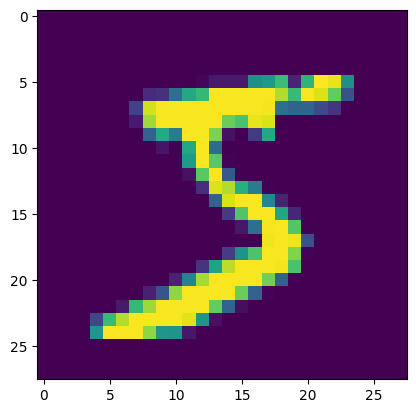

In [12]:
print(y_train[0], X_train.shape)
plt.imshow(X_train[0])

7 (10000, 28, 28)


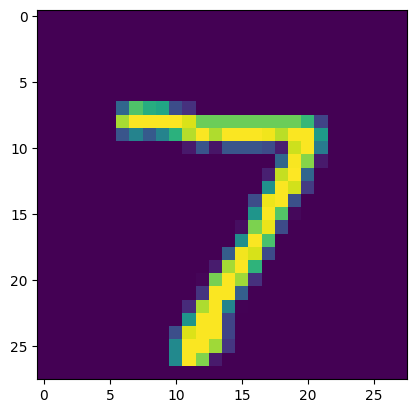

In [13]:
print(y_test[0], X_test.shape)
plt.imshow(X_test[0])

In [14]:
y_test = y_test.reshape(1, -1)[0]
print("y_test:", y_test)
X_train = X_train.reshape(X_train.shape[0], -1, 1)
X_test = X_test.reshape(X_test.shape[0], -1, 1)
X_train= X_train.astype('float64')
X_train/=255
X_test= X_test.astype('float64')
X_test/=255
X_train

y_test: [7 2 1 ... 4 5 6]


array([[[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       ...,

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]]])

### Data reduction

In [32]:
# I will leave only two classes zeroes and ones
train_idxs = np.logical_or(y_train == 1, y_train == 0)
X_train = X_train[train_idxs]
y_train = y_train[train_idxs]
test_idxs = np.logical_or(y_test == 1, y_test == 0)
X_test = X_test[test_idxs]
y_test = y_test[test_idxs]

### Algorithm


In [33]:
import numpy as np

In [34]:
def softmax_forward(X):
    """
    Compute the softmax activation for a given input vector X.
    X: Input vector (numpy array)
    softmax_result: Softmax activation result (numpy array)
    """
    exp_X = np.exp(X)
    softmax_result = exp_X / np.sum(exp_X)
    return softmax_result

def softmax_backward(Y, dL_dY):
    """
    Compute the gradient of the loss with respect to the input X using softmax.
    Y: softmax passed logits (numpy array)
    dL_dY: Gradient of the loss with respect to the output Y (numpy array)
    Returns dL_dX: Gradient of the loss with respect to the input X (numpy array)
    """
    N = len(Y)
    dZ_dX = np.empty([N, N])

    # Compute the diagonal and off-diagonal elements of the dZ_dX matrix
    for i in range(N):
        for j in range(i, N):
            # I obtain the following equalities when I manually calculate derivatives.
            if i != j:
                dZ_dX[i][j] = -Y[i] * Y[j]
                dZ_dX[j][i] = dZ_dX[i][j] # Because matrix is symmetric
            else:
                dZ_dX[i][i] = Y[i] * (1 - Y[i])

    # Apply chain rule
    dL_dX = np.matmul(dZ_dX, dL_dY)
    return dL_dX

In [35]:
def ReLU_forward(inputs):
  """
  inputs: Input vector (numpy array)
  """
  inputs[inputs < 0] = 0
  return inputs

def ReLU_backward(inputs, dL_dZ):
  """
  inputs: Input vector (numpy array)
  dL_dZ: Gradient of the loss with respect to the output Z (numpy array)
  """
  dL_dZ[inputs < 0] = 0
  return dL_dZ

In [36]:
def mtx_mult_backward(W, X, dL_dZ, with_respect_to_first=True):
  """
  W: Weights (numpy array with shape: (nxk))
  X: Input vector (numpy array with shape: (kxm))
  dL_dZ: Gradient of the loss with respect to the output Z = W * X (numpy array with shape: (nxm))
  with_respect_to_first: Indicate what derivatives should calculate. if true then function return dL_dW, else return dL_dX
  Returns dL_dW: Gradient of the loss with respect to the weights W (numpy array with shape: (nxk))
  """
  if with_respect_to_first:
    dL_dW = np.empty(W.shape)
    n, k = W.shape
    for i in range(n):
      for j in range(k):
        dL_dW[i][j] = np.dot(dL_dZ[i], X[j]) # It's equality we can easily get if we multiply correct all corresponding derivatives
    return dL_dW
  else:
    dL_dX = np.empty(X.shape)
    n, k = X.shape
    for i in range(n):
      for j in range(k):
        dL_dX[i][j] = np.dot(dL_dZ[:, j], W[:, i]) # It's equality we can easily get if we multiply correct all corresponding derivatives
    return dL_dX


### 1)
Just neural network with single linear layer(without biases) and softmax layer

In [37]:
def iteration(W, Xs, ys, learning_rate=0.01):
  dL_dW = np.zeros(W.shape) # gradient vector
  losses_sum = 0
  for i in range(len(Xs)):
    X = Xs[i]
    y = ys[i]
    Wx = np.matmul(W, X)
    softmax_Wx = softmax_forward(Wx)
    loss = np.log(softmax_Wx[y])
    losses_sum += loss # Needed to calculate mean loss for train dataset
    loss_backward = np.zeros(Wx.shape)
    loss_backward[y] = 1/softmax_Wx[y]
    sm_backward = softmax_backward(softmax_Wx, loss_backward)
    dL_dW += mtx_mult_backward(W, X, sm_backward)
  dL_dW /= len(Xs) # Calculate mean gradient vector
  W += dL_dW * learning_rate # Take a gradient step
  return losses_sum / len(Xs) # mean loss

def predict(W, Xs):
  y_pred = np.empty(len(Xs))
  for i in range(len(Xs)):
    Wx = np.matmul(W, Xs[i])
    softmax_Wx = softmax_forward(Wx)
    y_pred[i] = np.argmax(softmax_Wx)
  return y_pred

In [39]:
def training(X_train, y_train, X_test, y_test, learning_rate, eps):
  num_labels = len(np.unique(y_test))
  X_size = np.prod(X_train[0].shape)
  w_size = (num_labels, X_size)
  W = np.random.uniform(-1, 1, size=w_size)
  W_last = np.full(w_size, 2.0)
  epoch = 0
  while not np.all(np.abs(W - W_last) < eps):
    W_last = np.copy(W)
    loss = iteration(W, X_train, y_train, learning_rate)
    acc = np.sum(predict(W, X_test) == y_test) / len(y_test)
    print(f"Epoch: {epoch}")
    print(f"  Mean training loss: {loss}, test accuracy: {acc}")
    epoch += 1
  return W
learning_rate = 0.5
eps = 0.01 # Needed to stop training when all parameters change less than eps
W=training(X_train, y_train, X_test, y_test, learning_rate, eps)

Epoch: 0
  Mean training loss: [-0.30974539], test accuracy: 0.9442080378250591
Epoch: 1
  Mean training loss: [-0.16305642], test accuracy: 0.9612293144208038
Epoch: 2
  Mean training loss: [-0.12836488], test accuracy: 0.968321513002364
Epoch: 3
  Mean training loss: [-0.10934697], test accuracy: 0.9725768321513002
Epoch: 4
  Mean training loss: [-0.09688994], test accuracy: 0.9782505910165484


### 2)
This neural network has the following structure:
Linear layer(with biases), ReLU layer, Linear layer(with biases), Softmax layer

In [22]:
def predict2(W1, b1, W2, b2, Xs):
  y_pred = np.empty(len(Xs))
  for i in range(len(Xs)):
    # Layer 1
    x1 = np.matmul(W1, Xs[i])
    x2 = x1 + b1
    x3 = ReLU_forward(x2)
    # Layer 2
    x4 = np.matmul(W2, x3)
    x5 = x4+b2
    # Output layer
    softmax_x5 = softmax_forward(x5)
    y_pred[i] = np.argmax(softmax_x5)
  return y_pred

In [46]:
def iteration2(W1, b1, W2, b2, Xs, ys, learning_rate=0.01):
  dL_dW1 = np.zeros(W1.shape) # gradient vector
  dL_dB1 = np.zeros(b1.shape) # gradient vector
  dL_dW2 = np.zeros(W2.shape) # gradient vector
  dL_dB2 = np.zeros(b2.shape) # gradient vector
  losses_sum = 0
  for i in range(len(Xs)):
    X = Xs[i]
    y = ys[i]
    # Forwarding
    # Layer 1
    x1 = np.matmul(W1, Xs[i])
    x2 = x1 + b1
    x3 = ReLU_forward(x2)
    # Layer 2
    x4 = np.matmul(W2, x3)
    x5 = x4 + b2
    # Output layer
    softmax_x5 = softmax_forward(x5)
    loss = np.log(softmax_x5[y][0])

    losses_sum += loss # Needed to calculate mean loss for train dataset

    # Back propagation
    # Output layer back propagation
    loss_backward = np.zeros(softmax_x5.shape)
    loss_backward[y][0] = 1/softmax_x5[y][0]
    sm_backward = softmax_backward(softmax_x5, loss_backward)
    # Layer 2 back propagation
    dL_dB2 += sm_backward
    b2_backward = sm_backward
    dL_dW2 += mtx_mult_backward(W2, x3, b2_backward)
    w2_backward = mtx_mult_backward(W2, x3, b2_backward, with_respect_to_first=False) # dL_dx3
    # Layer 1 back propagation
    relu_backward = ReLU_backward(x2, w2_backward)
    dL_dB1 += relu_backward
    b1_backward = relu_backward
    dL_dW1 += mtx_mult_backward(W1, Xs[i], b1_backward)

  dL_dW1 /= len(Xs)
  dL_dB1 /= len(Xs)
  dL_dW2 /= len(Xs)
  dL_dB2 /= len(Xs)
  W1 += dL_dW1 * learning_rate # Take a gradient step
  b1 += dL_dB1 * learning_rate # Take a gradient step
  W2 += dL_dW2 * learning_rate # Take a gradient step
  b2 += dL_dB2 * learning_rate # Take a gradient step
  return losses_sum / len(Xs) # mean loss

def training2(X_train, y_train, X_test, y_test, learning_rate, eps):
  num_labels = len(np.unique(y_test))
  X_size = np.prod(X_train[0].shape)
  # Random initialization
  W1 = np.random.uniform(-1, 1, size=(num_labels, X_size))
  b1 = np.random.uniform(-1, 1, size=(num_labels, 1))
  W2 = np.random.uniform(-1, 1, size=(num_labels, num_labels))
  b2 = np.random.uniform(-1, 1, size=(num_labels, 1))
  # To save parameters from previous iteration
  W1_last = np.full(W1.shape, 2.0)
  b1_last = np.full(b1.shape, 2.0)
  W2_last = np.full(W2.shape, 2.0)
  b2_last = np.full(b2.shape, 2.0)
  epoch = 0 # Just for printing logs
  while not (np.all(np.abs(W1 - W1_last) < eps) and np.all(np.abs(b1 - b1_last) < eps) and np.all(np.abs(W2 - W2_last) < eps) and np.all(np.abs(b2 - b2_last) < eps)):
    W1_last = np.copy(W1)
    b1_last = np.copy(b1)
    W2_last = np.copy(W2)
    b2_last = np.copy(b2)
    loss = iteration2(W1, b1, W2, b2, X_train, y_train, learning_rate)
    acc = np.sum(predict2(W1, b1, W2, b2, X_test) == y_test) / len(y_test)
    print(f"Epoch: {epoch}")
    epoch+=1
    print(f"  Mean training loss: {loss}, test accuracy: {acc}")
  return [W1, b1, W2, b2]

In [48]:
learning_rate = 0.2
eps = 0.01
W1, b1, W2, b2 = training2(X_train, y_train, X_test, y_test, learning_rate, eps)

Epoch: 0
  Mean training loss: -2.270174241600115, test accuracy: 0.6364066193853428
Epoch: 1
  Mean training loss: -0.8156051694308727, test accuracy: 0.7508274231678487
Epoch: 2
  Mean training loss: -0.6305905139596325, test accuracy: 0.8217494089834515
Epoch: 3
  Mean training loss: -0.5327156080627411, test accuracy: 0.8600472813238771
Epoch: 4
  Mean training loss: -0.46892256842540003, test accuracy: 0.8888888888888888
Epoch: 5
  Mean training loss: -0.4201789756976428, test accuracy: 0.9125295508274232
Epoch: 6
  Mean training loss: -0.3802725584687277, test accuracy: 0.9271867612293144
Epoch: 7
  Mean training loss: -0.34670243483249036, test accuracy: 0.9390070921985816
Epoch: 8
  Mean training loss: -0.31822913219533, test accuracy: 0.9465721040189126
Epoch: 9
  Mean training loss: -0.29419076212077055, test accuracy: 0.9574468085106383
Epoch: 10
  Mean training loss: -0.2735385169169129, test accuracy: 0.9602836879432625
Epoch: 11
  Mean training loss: -0.2556396008545113, 